In [1]:
# The gp_sfh.py file conta"ins a simple GP framework that we'll be using
from gp_sfh import *
import gp_sfh_kernels

#--------------------------------------------------------------------------------------
# import FSPS and set up a fiducial set of parameters (dust, metallicity, IMF, etc.)
#--------------------------------------------------------------------------------------

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from copy import deepcopy
import hickle

import fsps
sp = fsps.StellarPopulation(imf_type=2, zcontinuous=1)
sp.params['imf_type'] = 1 # Chabrier
sp.params['logzsol'] = 0.0 # Solar metallicity
sp.params['dust_type'] = 2 # Calzetti
sp.params['dust2'] = 0.2
sp.params['sfh'] = 3
sp.params['add_neb_emission'] = True
sp.params['add_neb_continuum'] = True

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
import pandas as pd
import corner

In [2]:
kernel_params_MW_1dex = [1.0, 2500/1e3, 150/1e3, 0.03, 25/1e3]
kernel_params_dwarf_1dex = [1.0, 30/1e3, 150/1e3, 0.03, 10/1e3]
kernel_params_noon_1dex = [1.0, 200/1e3, 100/1e3, 0.03, 50/1e3]
kernel_params_highz_1dex = [1.0, 15/1e3, 16/1e3, 0.03, 6/1e3]

TCF20_scattervals = [0.17, 0.53, 0.24, 0.27]
kernel_params_MW_TCF20 = [np.sqrt(TCF20_scattervals[0]**2/(1 + (0.03)**2)), 2500/1e3, 150/1e3, 0.03*np.sqrt(TCF20_scattervals[0]**2/(1 + (0.03)**2)), 25/1e3]
kernel_params_dwarf_TCF20 = [np.sqrt(TCF20_scattervals[1]**2/(1 + (0.03)**2)), 30/1e3, 150/1e3, 0.03*np.sqrt(TCF20_scattervals[1]**2/(1 + (0.03)**2)), 10/1e3]
kernel_params_noon_TCF20 = [np.sqrt(TCF20_scattervals[2]**2/(1 + (0.03)**2)), 200/1e3, 100/1e3, 0.03*np.sqrt(TCF20_scattervals[2]**2/(1 + (0.03)**2)), 50/1e3]
kernel_params_highz_TCF20 = [np.sqrt(TCF20_scattervals[3]**2/(1 + (0.03)**2)), 15/1e3, 16/1e3, 0.03*np.sqrt(TCF20_scattervals[3]**2/(1 + (0.03)**2)), 6/1e3]


MW \sigma_eff = sqrt(C(\tau=0)): 1.000 dex
dwarf \sigma_eff = sqrt(C(\tau=0)): 1.000 dex
noon \sigma_eff = sqrt(C(\tau=0)): 1.000 dex
highz \sigma_eff = sqrt(C(\tau=0)): 1.000 dex


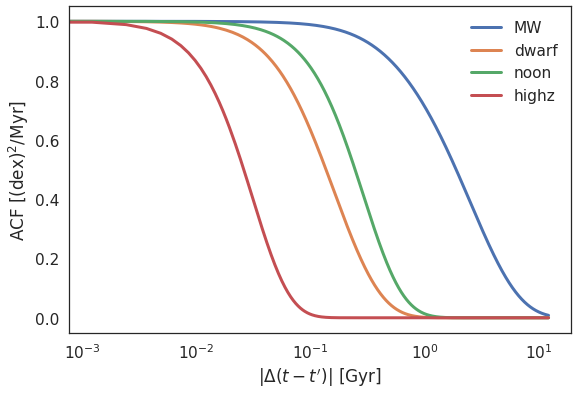

In [3]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]

plt.figure(figsize=(9,6))

for i, case in enumerate(cases):
    
    deltat = np.linspace(0,cosmo.age(zval).value,tarr_res)
    plt.plot(deltat, gp_sfh_kernels.extended_regulator_model_kernel_paramlist(deltat, case_params[i]),lw=3,label=case)
    
    print(case+r' \sigma_eff = sqrt(C(\tau=0)): %.3f dex' %(np.sqrt(gp_sfh_kernels.extended_regulator_model_kernel_paramlist(deltat, case_params[i])[0])))
    
plt.legend(edgecolor='w')
plt.xscale('log');
#plt.xlim(1e-2,)
# plt.yscale('log')
# plt.ylim(1e-3,1e1)
plt.xlabel('$|\Delta (t-t\')|$ [Gyr]')
plt.ylabel('ACF [(dex)$^2$/Myr]')
plt.show()

MW 11.44624972492062 0.650197639000601
dwarf 11.863505860340725 0.2808798555492617
noon 11.793723023420426 0.34976403872716755
highz 11.962468128955525 0.15782922878271438


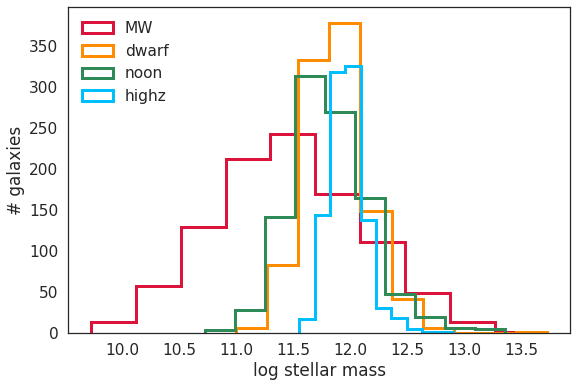

In [4]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

for i, case in enumerate(cases):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)
    plt.hist(np.log10(case1.mstar),histtype='step',lw=3,label=case,color=case_colors[i])
    print(case, np.median(np.log10(case1.mstar)), np.std(np.log10(case1.mstar)))
plt.legend(edgecolor='w')
#plt.xscale('log');plt.yscale('log')
#plt.ylim(1e-3,1e1)
plt.xlabel('log stellar mass')
plt.ylabel('# galaxies')
plt.savefig('figures/massdist_1dex.png')
plt.show()
    

100%|██████████| 1000/1000 [00:00<00:00, 13804.23it/s]


<Figure size 648x432 with 0 Axes>

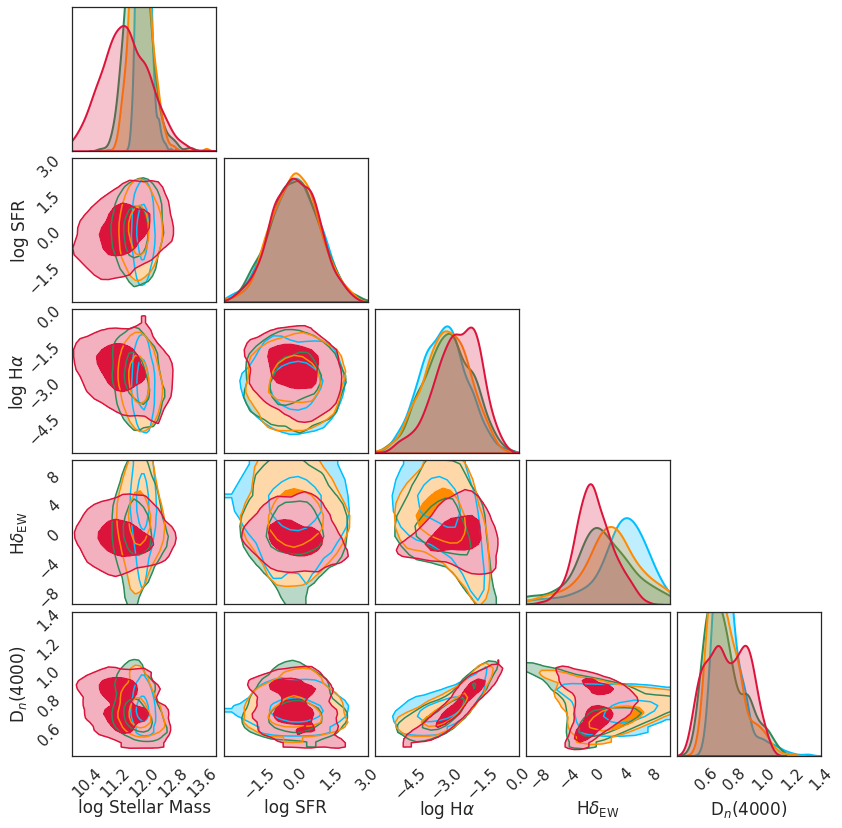

In [5]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(10,14,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]

for i, case in reversed(list(enumerate(cases))):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)

    case1.calc_spectral_features(massnorm = True)
    
    temphd = np.array(case1.hdelta_ews.copy())
    #temphd[temphd < -11] = -11
    
    tempha = np.array(np.log10(case1.ha_lums).copy())
    #tempha[tempha < -6] = -6
    
    case1_specfeatures = np.vstack((np.log10(case1.mstar), 
                                    (np.array(case1.samples)[0:,0]),
                                    tempha, temphd, case1.dn4000_vals))

    if i==3:
        fig = corner.corner(case1_specfeatures.T, 
                      labels=['log Stellar Mass', 'log SFR', r'log H$\alpha$', r'H$\delta_{\rm EW}$', 'D$_n$(4000)'],
                      levels=[1 - np.exp(-(1/1)**2/2),1 - np.exp(-(2/1)**2/2)], # quantiles=(0.16,0.84), 
                      plot_datapoints=False, fill_contours=True, smooth=smoothval,
                      color = case_colors[i], hist_kwargs={'lw':0, 'density':True})
        axes = np.array(fig.axes).reshape((5,5))
        all_specfeatures = case1_specfeatures
        
        for kdei in range(5):
            axkde = axes[kdei, kdei]
            sns.kdeplot(case1_specfeatures[kdei,0:],shade=True,lw=2,color=case_colors[i],ax=axkde)
            axkde.set_ylabel('')
        
    elif i<4:
        fig = corner.corner(case1_specfeatures.T, 
              levels=[1 - np.exp(-(1/1)**2/2),1 - np.exp(-(2/1)**2/2)], #quantiles=(0.16,0.84), 
              plot_datapoints=False, fill_contours=True, smooth=smoothval,
              color = case_colors[i], fig = fig, hist_kwargs={'lw':0, 'density':True})
        
        for kdei in range(5):
            axkde = axes[kdei, kdei]
            sns.kdeplot(case1_specfeatures[kdei,0:],shade=True,lw=2,color=case_colors[i],ax=axkde)
            axkde.set_ylabel('')
        all_specfeatures = np.hstack((all_specfeatures, case1_specfeatures))
        
# Extract the axes


lims = [(10,14),(-3,3),(-6,0),(-10,10),(0.4,1.4)]


for i in range(5):
    ax = axes[i, i]
    ax.set_xlim(lims[i])
    
    for j in range(i):
        ax = axes[i,j]
        ax.set_xlim(lims[j])
        ax.set_ylim(lims[i])
#plt.savefig('figures/fig4_panel2_1dex.png',bbox_inches='tight')
plt.show()

In [6]:
case1.bands

['v',
 'u',
 'b',
 'buser_b',
 'cousins_r',
 'cousins_i',
 'cfht_b',
 'cfht_r',
 'cfht_i',
 '2mass_j',
 '2mass_h',
 '2mass_ks',
 'sdss_u',
 'sdss_g',
 'sdss_r',
 'sdss_i',
 'sdss_z',
 'wfpc2_f255w',
 'wfpc2_f300w',
 'wfpc2_f336w',
 'wfpc2_f439w',
 'wfpc2_f450w',
 'wfpc2_f555w',
 'wfpc2_f606w',
 'wfpc2_f814w',
 'wfpc2_f850lp',
 'wfc_acs_f435w',
 'wfc_acs_f475w',
 'wfc_acs_f555w',
 'wfc_acs_f606w',
 'wfc_acs_f625w',
 'wfc_acs_f775w',
 'wfc_acs_f814w',
 'wfc_acs_f850lp',
 'wfc3_uvis_f218w',
 'wfc3_uvis_f225w',
 'wfc3_uvis_f275w',
 'wfc3_uvis_f336w',
 'wfc3_uvis_f390w',
 'wfc3_uvis_f438w',
 'wfc3_uvis_f475w',
 'wfc3_uvis_f555w',
 'wfc3_uvis_f606w',
 'wfc3_uvis_f775w',
 'wfc3_uvis_f814w',
 'wfc3_uvis_f850lp',
 'wfc3_ir_f098m',
 'wfc3_ir_f105w',
 'wfc3_ir_f110w',
 'wfc3_ir_f125w',
 'wfc3_ir_f140w',
 'wfc3_ir_f160w',
 'irac_1',
 'irac_2',
 'irac_3',
 'irac_4',
 'isaac_ks',
 'fors_v',
 'fors_r',
 'nicmos_f110w',
 'nicmos_f160w',
 'galex_fuv',
 'galex_nuv',
 'des_g',
 'des_r',
 'des_i',
 'des_z

<Figure size 648x432 with 0 Axes>

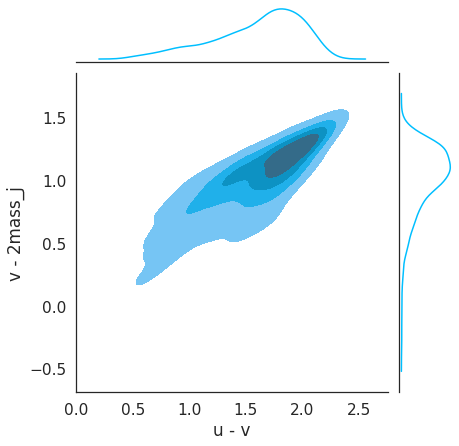

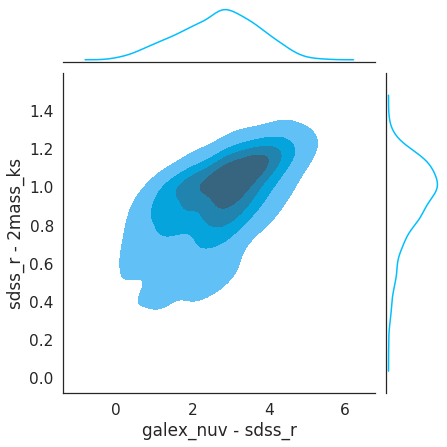

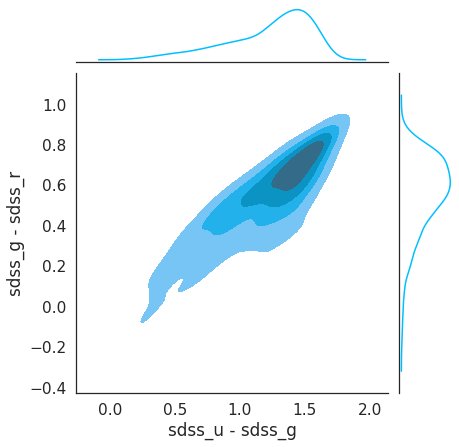

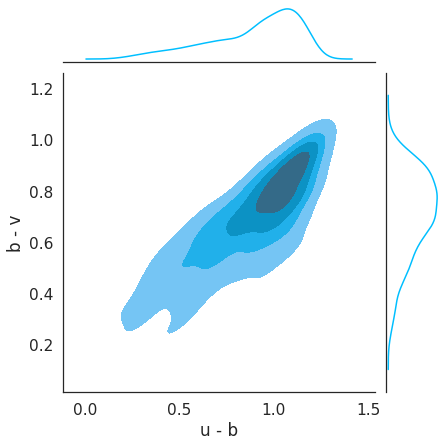

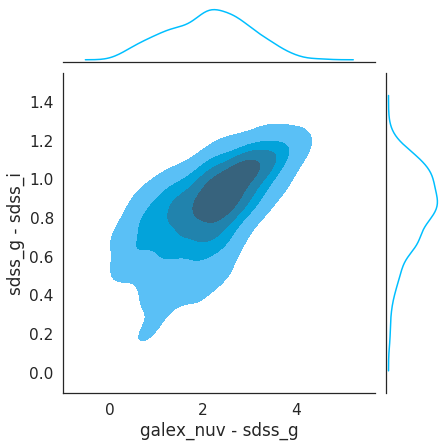

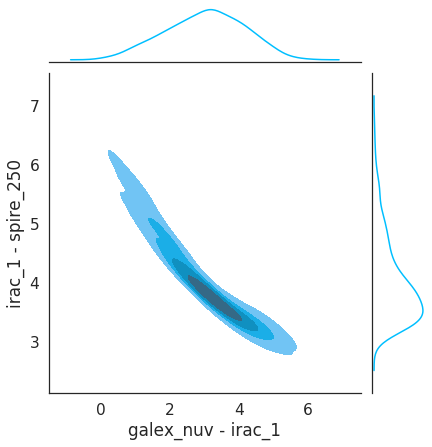

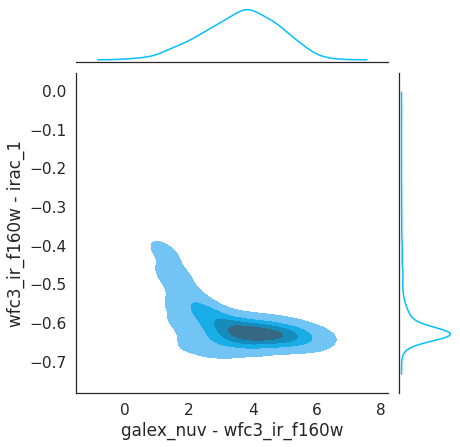

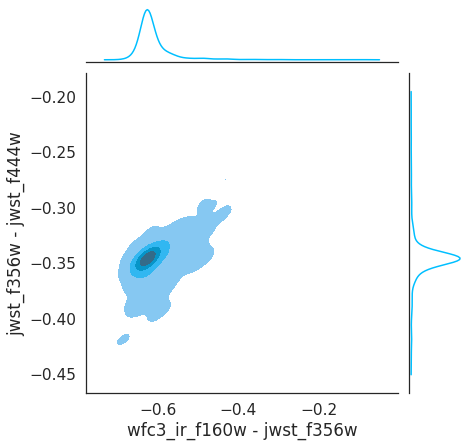

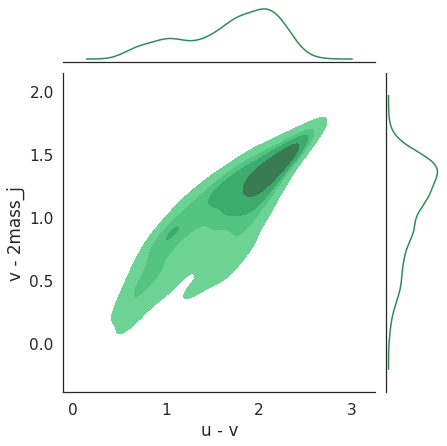

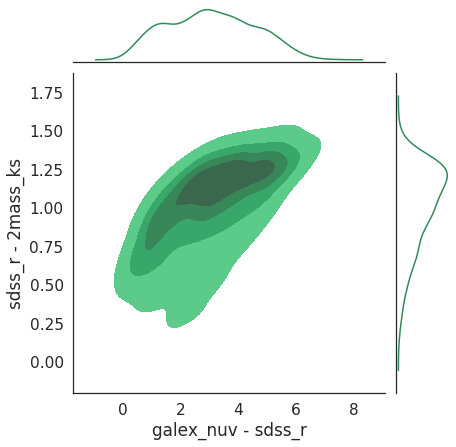

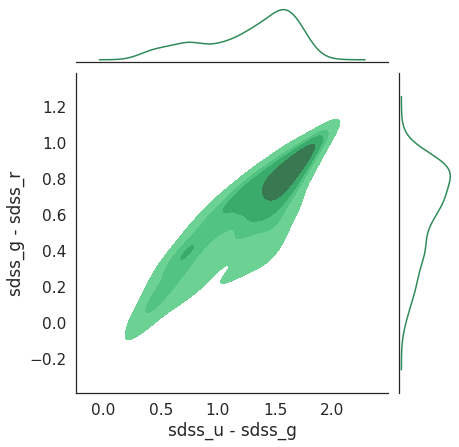

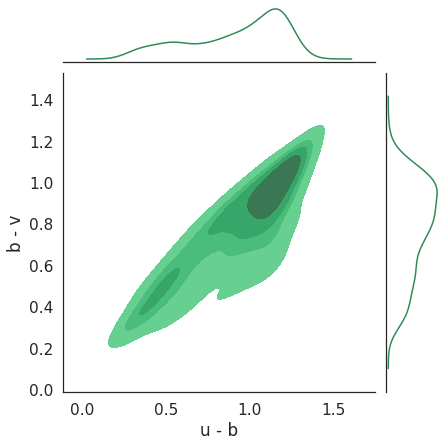

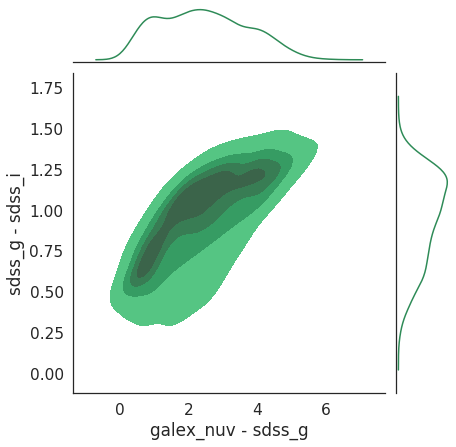

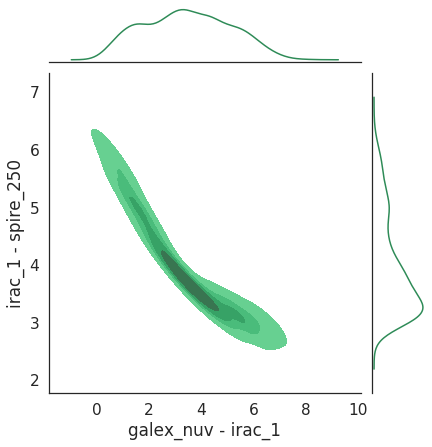

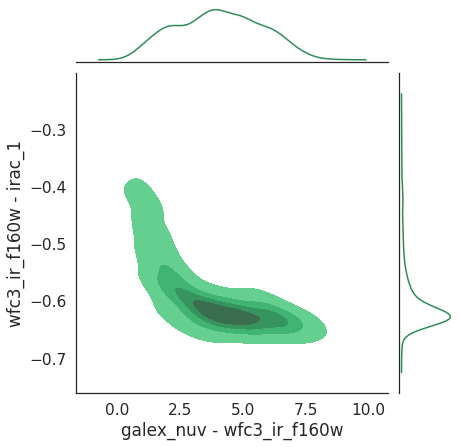

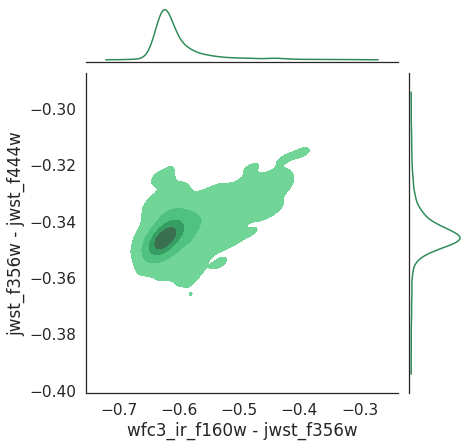

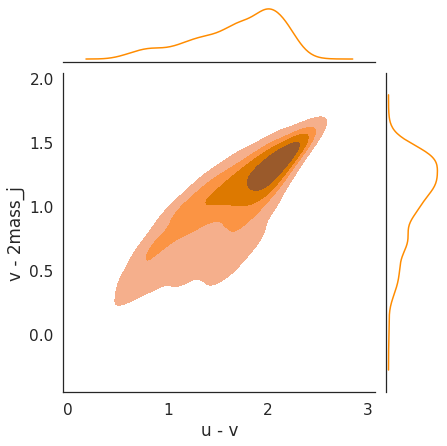

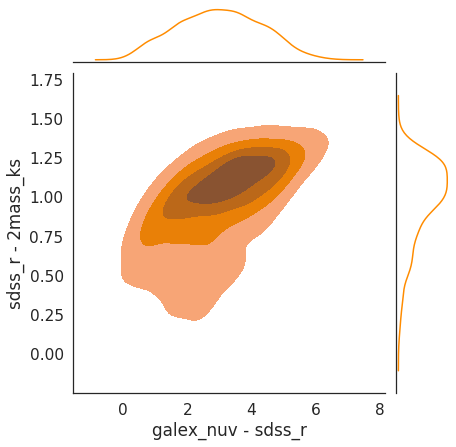

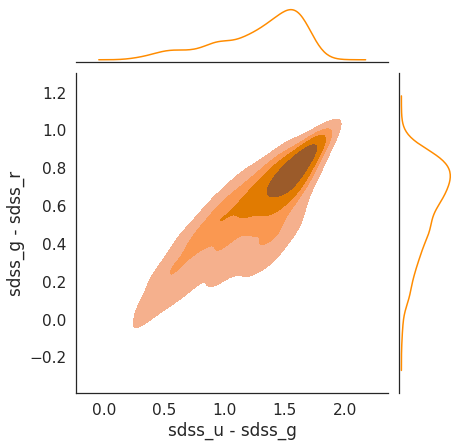

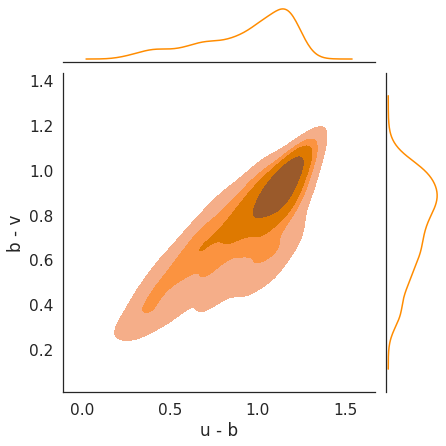

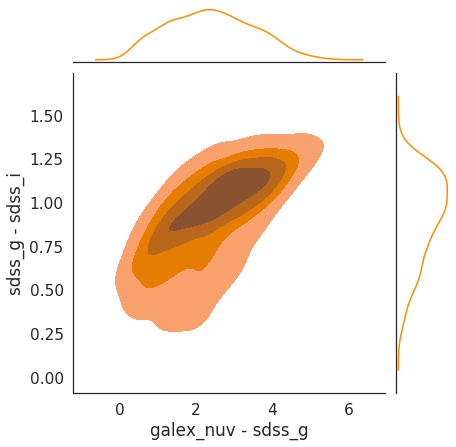

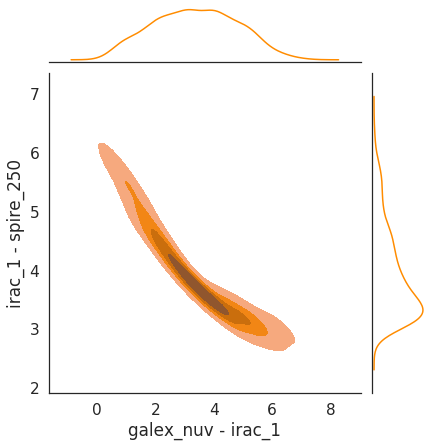

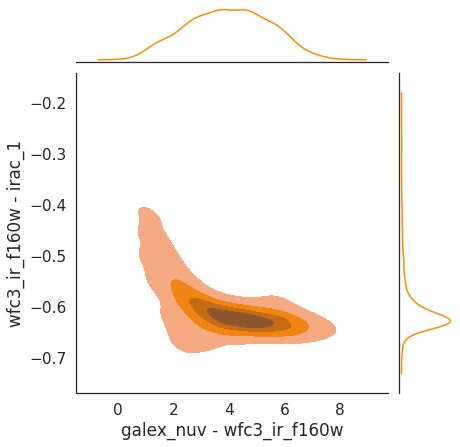

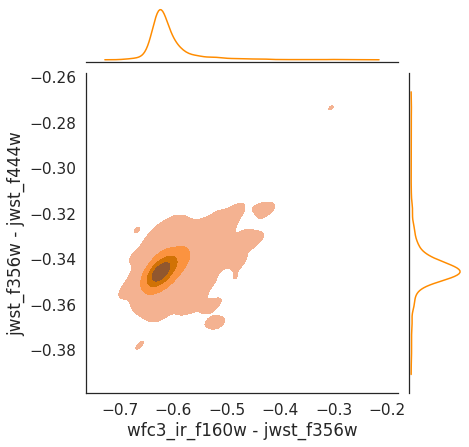

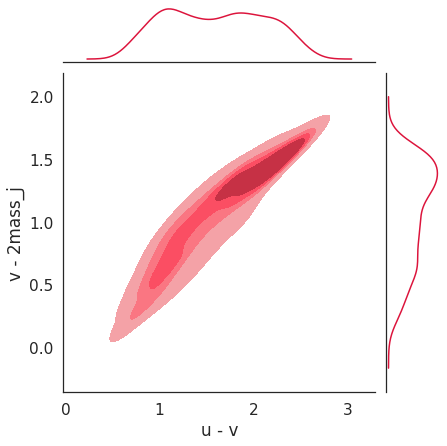

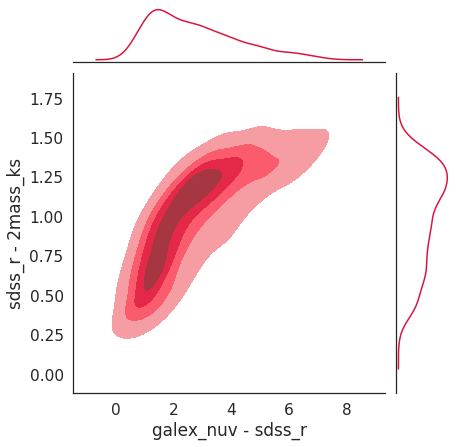

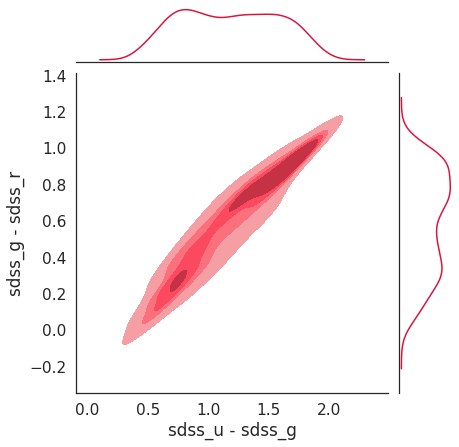

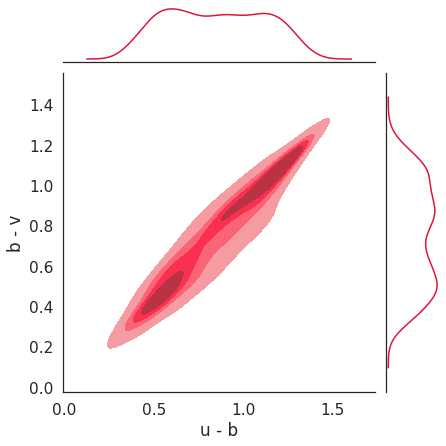

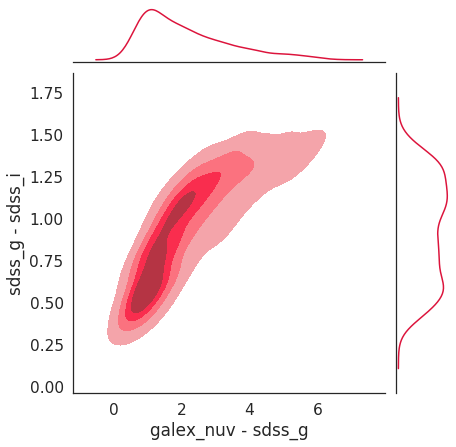

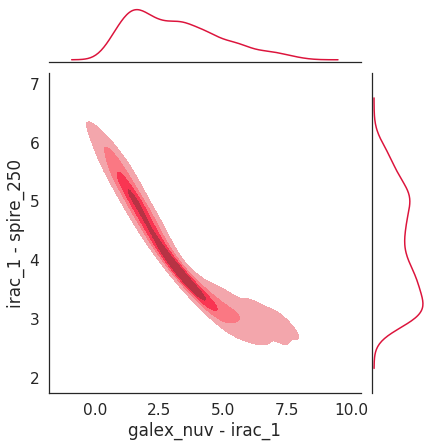

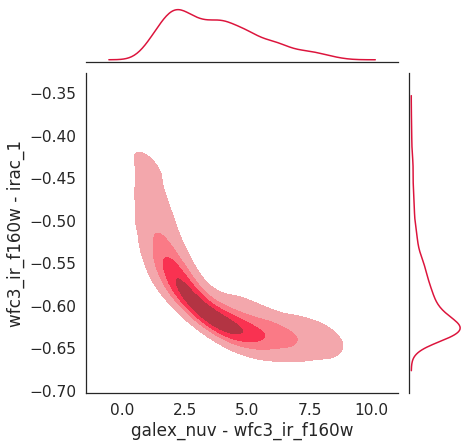

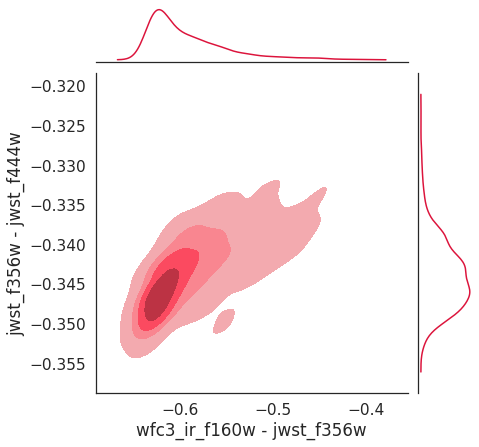

In [52]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(10,14,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]

for i, case in reversed(list(enumerate(cases))):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)


    #levels = [1-0.95,1-0.68,1.]
    levels = 5
    
    # Standard color-color plots
    make_color_color_plot(case1, 'u','v','2mass_j',case_colors[i],levels=levels)
    make_color_color_plot(case1, 'galex_nuv','sdss_r','2mass_ks',case_colors[i],levels=levels)
    
    # Older formats
    make_color_color_plot(case1, 'sdss_u','sdss_g','sdss_r',case_colors[i],levels=levels)
    make_color_color_plot(case1, 'u','b','v',case_colors[i],levels=levels)
    make_color_color_plot(case1, 'galex_nuv','sdss_g','sdss_i',case_colors[i],levels=levels)

    # interesting things to look at
    make_color_color_plot(case1, 'galex_nuv','irac_1','spire_250',case_colors[i],levels=levels)
    make_color_color_plot(case1, 'galex_nuv','wfc3_ir_f160w','irac_1',case_colors[i],levels=levels)
    make_color_color_plot(case1, 'wfc3_ir_f160w','jwst_f356w','jwst_f444w',case_colors[i],levels=levels)

    

In [6]:
sns.set_style('ticks', {'axes.grid' : True})

In [7]:
def make_color_color_plot(case1, band1 = 'u', band2 = 'b', band3 = 'v',color = case_colors[0],levels=[0.16,0.5,0.84], axlim = None, save_fname = None, flipplot = True):

    

    color1_name = band1+' - '+band2
    color2_name = band2+' - '+band3

    color1 = np.array(case1.filtmags)[0:, case1.bands.index(band1)] - np.array(case1.filtmags)[0:, case1.bands.index(band2)]
    color2 = np.array(case1.filtmags)[0:, case1.bands.index(band2)] - np.array(case1.filtmags)[0:, case1.bands.index(band3)]

    if flipplot == True:
        fig = sns.jointplot(color2, color1, kind='kde', levels=levels ,color = color,fill=True)
        fig.set_axis_labels(color2_name, color1_name)
    else:
        fig = sns.jointplot(color1, color2, kind='kde', levels=levels ,color = color,fill=True)
        fig.set_axis_labels(color1_name, color2_name)
        
    if axlim is not None:
        
        fig.ax_marg_x.set_xlim(axlim[0], axlim[1])
        fig.ax_marg_y.set_ylim(axlim[2], axlim[3])
    #plt.scatter(color1, color2,s=100)
    #fig.set_xlabel(color1_name)
    #fig.set_ylabel(color2_name)
    plt.tight_layout()
    if save_fname is not None:
        plt.savefig('figures/'+save_fname,bbox_inches='tight', dpi=300)
    plt.show()
    
    return


# Standard UVJ

<Figure size 648x432 with 0 Axes>

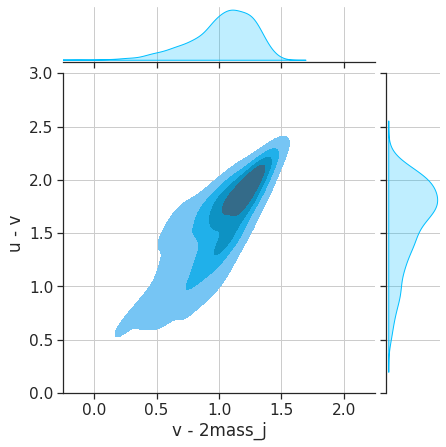

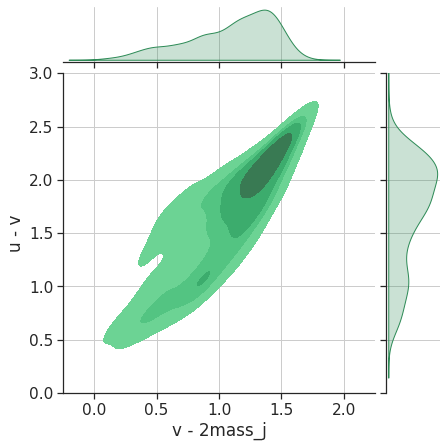

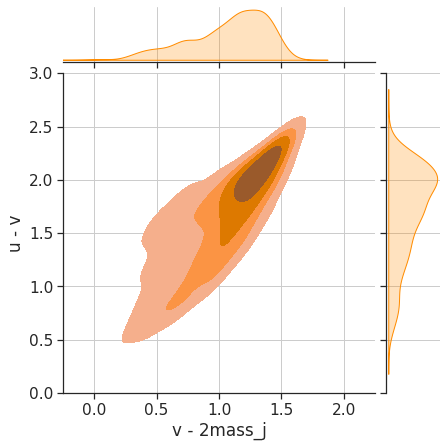

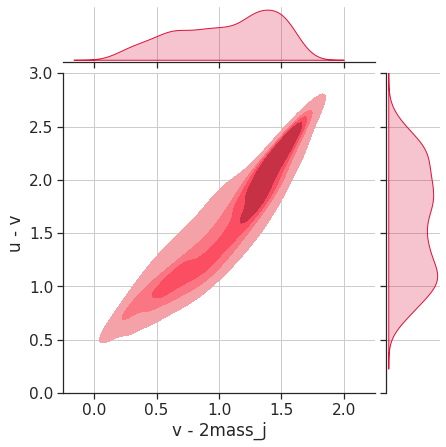

In [82]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(10,14,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]

for i, case in reversed(list(enumerate(cases))):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)


    #levels = [1-0.95,1-0.68,1.]
    levels = 5
    
    # Standard color-color plots
    make_color_color_plot(case1, 'u','v','2mass_j',case_colors[i],
                          levels=levels, axlim=[-0.25,2.25,0.,3.], save_fname='UVJ_color_'+case+'.png')

# FUV-V-Wise W3 based on Leja+19
https://iopscience.iop.org/article/10.3847/2041-8213/ab2f8c

<Figure size 648x432 with 0 Axes>

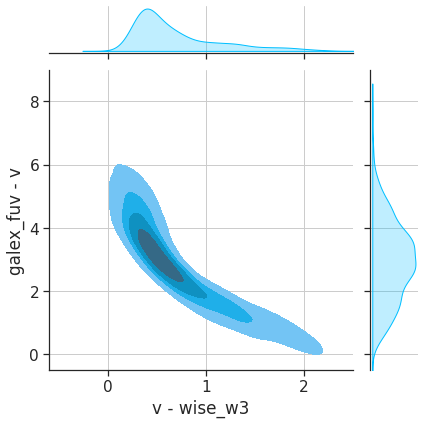

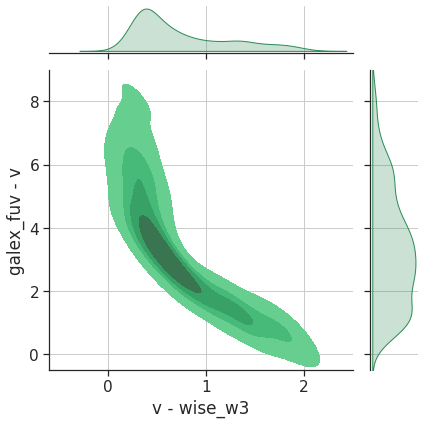

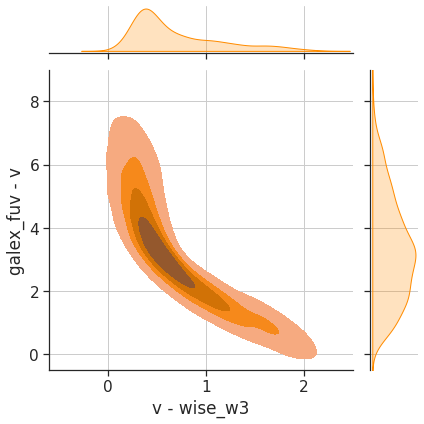

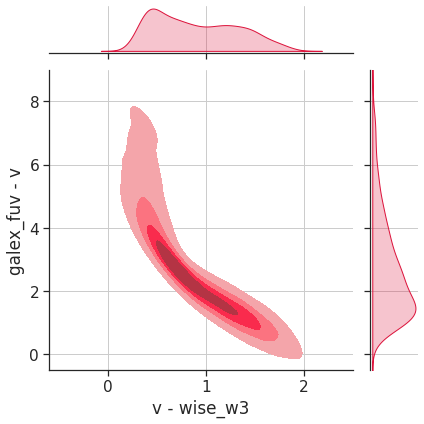

In [85]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(10,14,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]

for i, case in reversed(list(enumerate(cases))):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)


    #levels = [1-0.95,1-0.68,1.]
    levels = 5
    
    # Standard color-color plots
    
    # based on Leja+19 https://iopscience.iop.org/article/10.3847/2041-8213/ab2f8c
    make_color_color_plot(case1, 'galex_fuv','v','wise_w3',case_colors[i],
                          levels=levels, axlim=[-0.6,2.5,-0.5,9.],save_fname='FUV_V_W3_color_'+case+'.png')

# NUV-r-Ks

<Figure size 648x432 with 0 Axes>

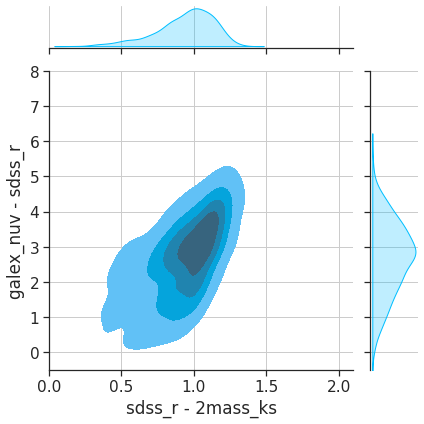

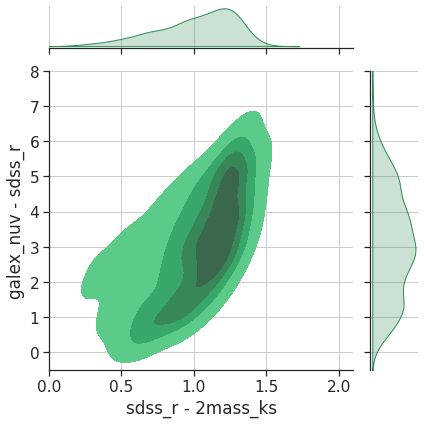

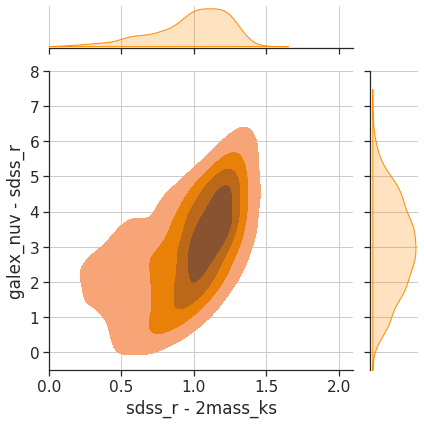

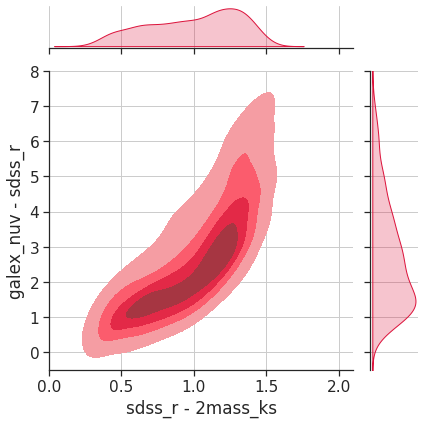

In [8]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(10,14,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]

for i, case in reversed(list(enumerate(cases))):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)


    #levels = [1-0.95,1-0.68,1.]
    levels = 5
    
    # Standard color-color plots
    
    # based on Leja+19 https://iopscience.iop.org/article/10.3847/2041-8213/ab2f8c
    make_color_color_plot(case1, 'galex_nuv','sdss_r','2mass_ks',case_colors[i],
                          levels=levels, axlim=[0.0,2.1,-0.5,8.],save_fname='NUVrk_color_'+case+'.png')

# NUV-F160w-IRAC1.6

<Figure size 648x432 with 0 Axes>

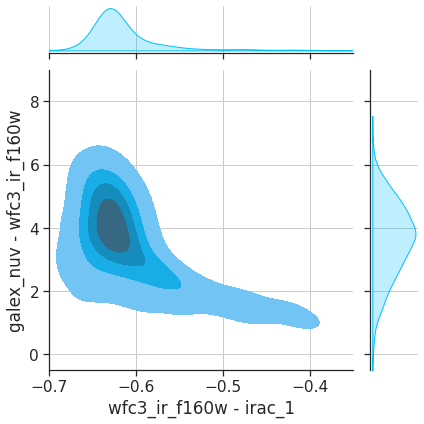

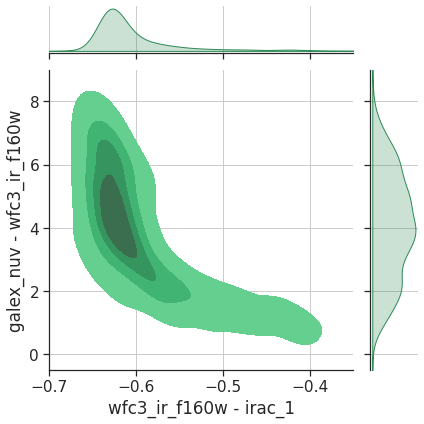

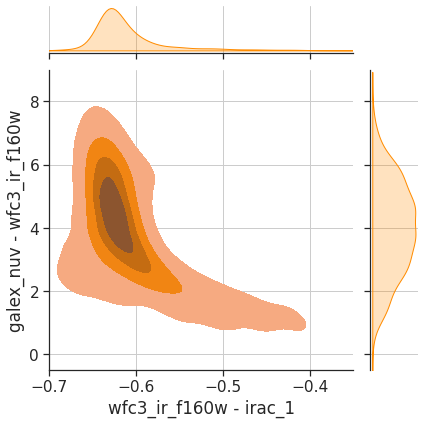

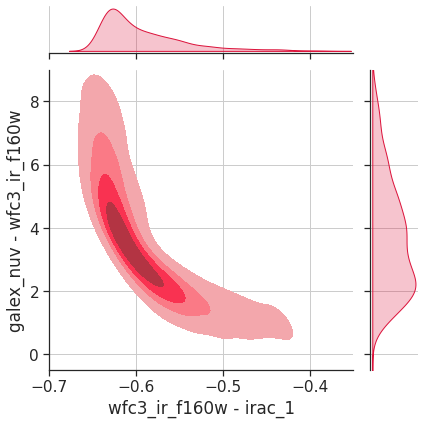

In [91]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(10,14,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]

for i, case in reversed(list(enumerate(cases))):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)


    #levels = [1-0.95,1-0.68,1.]
    levels = 5
    
    # Standard color-color plots
    
    # based on Leja+19 https://iopscience.iop.org/article/10.3847/2041-8213/ab2f8c
    make_color_color_plot(case1, 'galex_nuv','wfc3_ir_f160w','irac_1',case_colors[i],
                          levels=levels, axlim=[-0.7,-0.35,-0.5,9.],save_fname='NUV-160-irac1_color_'+case+'.png')

# 'wfc3_ir_f160w','jwst_f356w','jwst_f444w'

<Figure size 648x432 with 0 Axes>

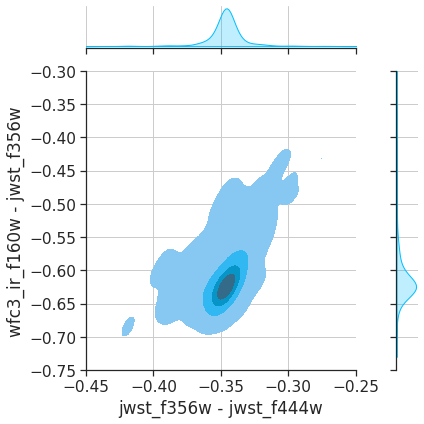

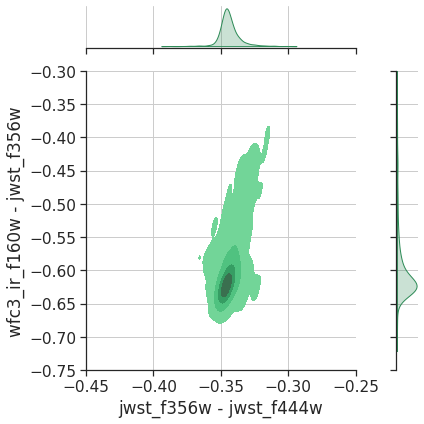

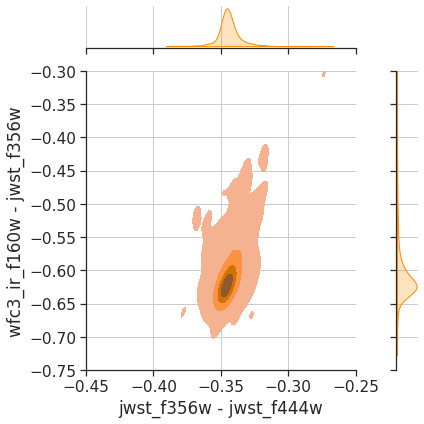

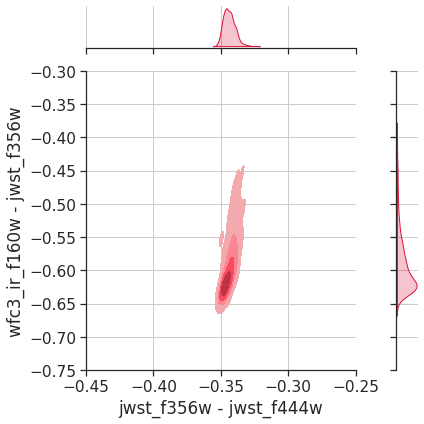

In [93]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(10,14,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]

for i, case in reversed(list(enumerate(cases))):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)


    #levels = [1-0.95,1-0.68,1.]
    levels = 5
    
    # Standard color-color plots
    
    # based on Leja+19 https://iopscience.iop.org/article/10.3847/2041-8213/ab2f8c
    make_color_color_plot(case1, 'wfc3_ir_f160w','jwst_f356w','jwst_f444w',case_colors[i],
                          levels=levels, axlim=[-0.45,-0.25,-0.75,-0.3],save_fname='F160-f356-f444_color_'+case+'.png')

# try some SFH exploration

In [ ]:
case1.colo

# galaxies:  12


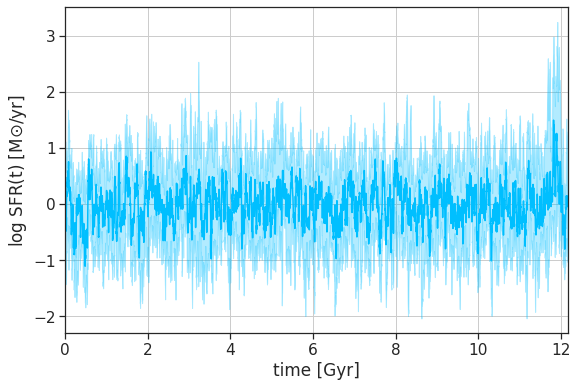

# galaxies:  19


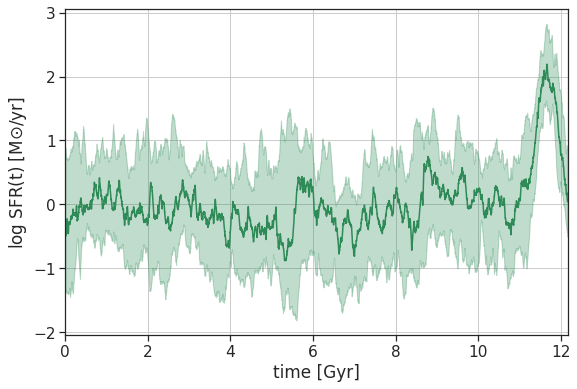

# galaxies:  29


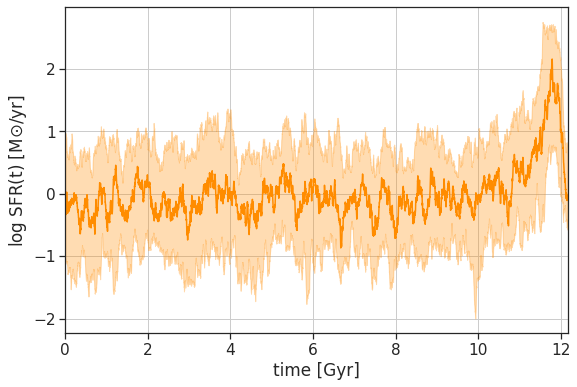

# galaxies:  2


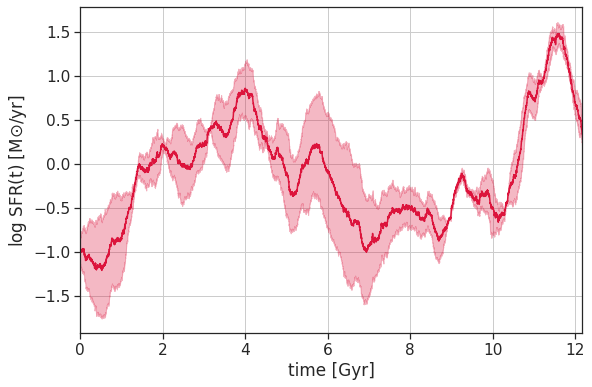

In [30]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(10,14,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]

for i, case in reversed(list(enumerate(cases))):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)


    band1 = 'galex_nuv'
    band2 = 'sdss_r'
    band3 = '2mass_ks'

    color1_name = band1+' - '+band2
    color2_name = band2+' - '+band3

    color1 = np.array(case1.filtmags)[0:, case1.bands.index(band1)] - np.array(case1.filtmags)[0:, case1.bands.index(band2)]
    color2 = np.array(case1.filtmags)[0:, case1.bands.index(band2)] - np.array(case1.filtmags)[0:, case1.bands.index(band3)]


    #levels = [1-0.95,1-0.68,1.]
    levels = 5

    # Standard color-color plots

    # based on Leja+19 https://iopscience.iop.org/article/10.3847/2041-8213/ab2f8c
    # make_color_color_plot(case1, 'galex_nuv','sdss_r','2mass_ks',case_colors[i],
    #                       levels=levels, axlim=[0.0,2.1,-0.5,8.],save_fname='NUVrk_color_'+case+'.png')


    mask = (color2 < 0.5) & (color1 > 2.0)
    print('# galaxies: ',np.sum(mask))

    plt.figure(figsize=(9,6))
    plt.plot(case1.tarr, np.nanmedian(case1.samples[mask, 0:],0), color = case_colors[i])
    plt.fill_between(case1.tarr, 
                     np.nanpercentile(case1.samples[mask, 0:],16,0), 
                     np.nanpercentile(case1.samples[mask, 0:],84,0), alpha=0.3, color = case_colors[i])
    plt.xlabel('time [Gyr]'); plt.xlim(0,np.amax(case1.tarr))
    plt.ylabel('log SFR(t) [M$\odot$/yr]')
    plt.savefig('figures/colorselectedSFH_'+case+'.png',bbox_inches='tight')
    plt.show()

# galaxies:  16


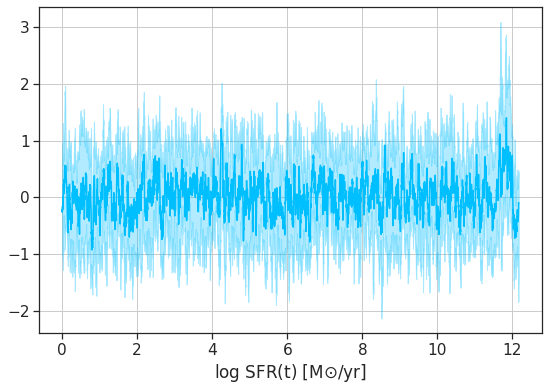

# galaxies:  27


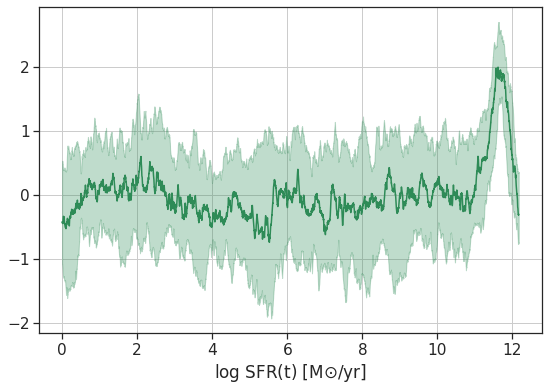

# galaxies:  36


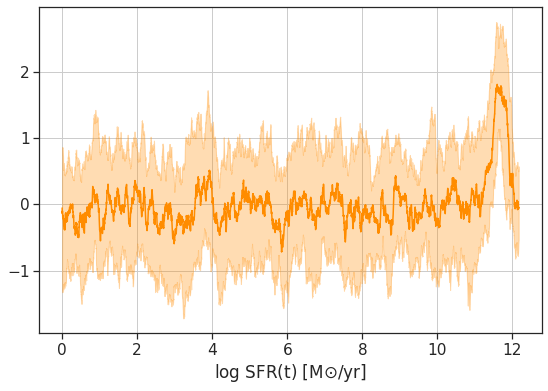

# galaxies:  2


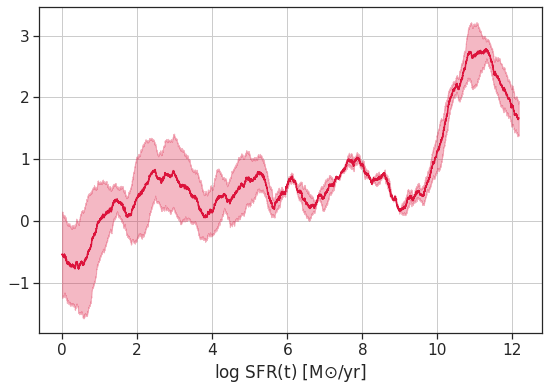

In [26]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(10,14,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]

for i, case in reversed(list(enumerate(cases))):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)


    band1 = 'u'
    band2 = 'v'
    band3 = '2mass_j'

    color1_name = band1+' - '+band2
    color2_name = band2+' - '+band3

    color1 = np.array(case1.filtmags)[0:, case1.bands.index(band1)] - np.array(case1.filtmags)[0:, case1.bands.index(band2)]
    color2 = np.array(case1.filtmags)[0:, case1.bands.index(band2)] - np.array(case1.filtmags)[0:, case1.bands.index(band3)]


    #levels = [1-0.95,1-0.68,1.]
    levels = 5

    # Standard color-color plots

    # based on Leja+19 https://iopscience.iop.org/article/10.3847/2041-8213/ab2f8c
    # make_color_color_plot(case1, 'galex_nuv','sdss_r','2mass_ks',case_colors[i],
    #                       levels=levels, axlim=[0.0,2.1,-0.5,8.],save_fname='NUVrk_color_'+case+'.png')


    mask = (color2 < 0.75) & (color1 > 1.5)
    print('# galaxies: ',np.sum(mask))

    plt.figure(figsize=(9,6))
    plt.plot(case1.tarr, np.nanmedian(case1.samples[mask, 0:],0), color = case_colors[i])
    plt.fill_between(case1.tarr, 
                     np.nanpercentile(case1.samples[mask, 0:],16,0), 
                     np.nanpercentile(case1.samples[mask, 0:],84,0), alpha=0.3, color = case_colors[i])
    plt.xlabel('time [Gyr]')
    plt.ylabel('log SFR(t) [M$\odot$/yr]')
    plt.show()

# galaxies:  535


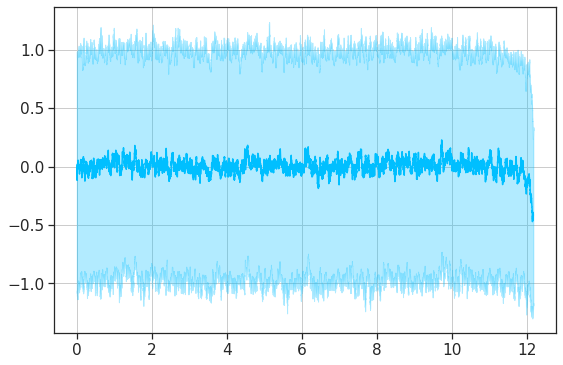

# galaxies:  607


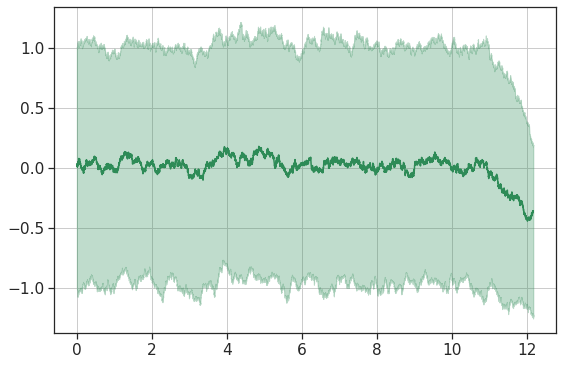

# galaxies:  598


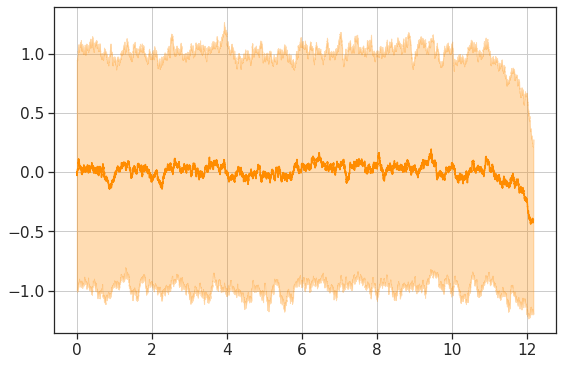

# galaxies:  519


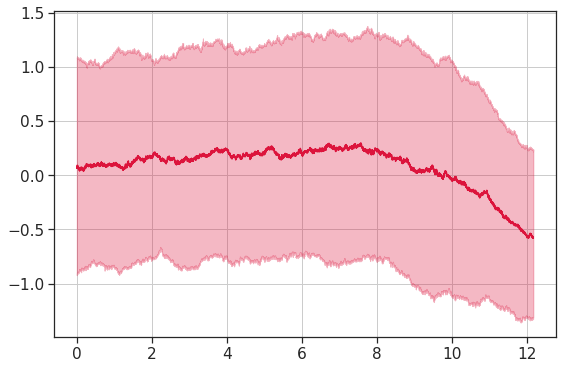

In [25]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(10,14,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]

for i, case in reversed(list(enumerate(cases))):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)


    band1 = 'u'
    band2 = 'v'
    band3 = '2mass_j'

    color1_name = band1+' - '+band2
    color2_name = band2+' - '+band3

    color1 = np.array(case1.filtmags)[0:, case1.bands.index(band1)] - np.array(case1.filtmags)[0:, case1.bands.index(band2)]
    color2 = np.array(case1.filtmags)[0:, case1.bands.index(band2)] - np.array(case1.filtmags)[0:, case1.bands.index(band3)]


    #levels = [1-0.95,1-0.68,1.]
    levels = 5

    # Standard color-color plots

    # based on Leja+19 https://iopscience.iop.org/article/10.3847/2041-8213/ab2f8c
    # make_color_color_plot(case1, 'galex_nuv','sdss_r','2mass_ks',case_colors[i],
    #                       levels=levels, axlim=[0.0,2.1,-0.5,8.],save_fname='NUVrk_color_'+case+'.png')


    mask = (color2 > 1.0) & (color1 > 1.5)
    print('# galaxies: ',np.sum(mask))

    plt.figure(figsize=(9,6))
    plt.plot(case1.tarr, np.nanmedian(case1.samples[mask, 0:],0), color = case_colors[i])
    plt.fill_between(case1.tarr, 
                     np.nanpercentile(case1.samples[mask, 0:],16,0), 
                     np.nanpercentile(case1.samples[mask, 0:],84,0), alpha=0.3, color = case_colors[i])
    plt.show()